Topic 3. Classification, Decision Trees and k Nearest Neighbors
https://mlcourse.ai/book/topic03/topic03_decision_trees_kNN.html

1. Introduction
Before we dive into the material for this week’s article, let’s talk about the kind of problem that we are going to solve and its place in the exciting field of machine learning. T. Mitchell’s book “Machine Learning” (1997) gives a classic, general definition of machine learning as follows:

A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E.

In the various problem settings T, P, and E can refer to completely different things. Some of the most popular tasks T in machine learning are the following:

classification of an instance to one of the categories based on its features;

regression – prediction of a numerical target feature based on other features of an instance;

clustering – identifying partitions of instances based on the features of these instances so that the members within the groups are more similar to each other than those in the other groups;

anomaly detection – search for instances that are “greatly dissimilar” to the rest of the sample or to some group of instances;

and so many more.

A good overview is provided in the “Machine Learning basics” chapter of “Deep Learning” (by Ian Goodfellow, Yoshua Bengio, Aaron Courville, 2016).

Experience E refers to data (we can’t go anywhere without it). Machine learning algorithms can be divided into those that are trained in supervised or unsupervised manner. In unsupervised learning tasks, one has a set consisting of instances described by a set of features. In supervised learning problems, there’s also a target variable, which is what we would like to be able to predict, known for each instance in a training set.

Example
Classification and regression are supervised learning problems. For example, as a credit institution, we may want to predict loan defaults based on the data accumulated about our clients. Here, the experience E is the available training data: a set of instances (clients), a collection of features (such as age, salary, type of loan, past loan defaults, etc.) for each, and a target variable (whether they defaulted on the loan). This target variable is just a fact of loan default (1 or 0), so recall that this is a (binary) classification problem. If you were instead predicting by how much time the loan payment is overdue, this would become a regression problem.

Finally, the third term used in the definition of machine learning is a metric of the algorithm’s performance evaluation P. Such metrics differ for various problems and algorithms, and we’ll discuss them as we study new algorithms. For now, we’ll refer to a simple metric for classification algorithms, the proportion of correct answers – accuracy – on the test set.

Let’s take a look at two supervised learning problems: classification and regression.

2. Decision Tree
We begin our overview of classification and regression methods with one of the most popular ones – a decision tree. Decision trees are used in everyday life decisions, not just in machine learning. Flow diagrams are actually visual representations of decision trees. For example, Higher School of Economics publishes information diagrams to make the lives of its employees easier. Here is a snippet of instructions for publishing a paper on the Institution portal.

../../_images/topic3_hse_instruction.png
In terms of machine learning, one can see it as a simple classifier that determines the appropriate form of publication (book, article, chapter of the book, preprint, publication in the “Higher School of Economics and the Media”) based on the content (book, pamphlet, paper), type of journal, original publication type (scientific journal, proceedings), etc.

A decision tree is often a generalization of the experts’ experience, a means of sharing knowledge of a particular process. For example, before the introduction of scalable machine learning algorithms, the credit scoring task in the banking sector was solved by experts. The decision to grant a loan was made on the basis of some intuitively (or empirically) derived rules that could be represented as a decision tree.

../../_images/credit_scoring_toy_tree_english.png
In our next case, we solve a binary classification problem (approve/deny a loan) based on the “Age”, “Home-ownership”, “Income”, and “Education” features.

The decision tree as a machine learning algorithm is essentially the same thing as the diagram shown above; we incorporate a stream of logical rules of the form “feature 
 value is less than 
 and feature 
 value is less than 
 … => Category 1” into a tree-like data structure. The advantage of this algorithm is that they are easily interpretable. For example, using the above scheme, the bank can explain to the client why they were denied for a loan: e.g the client does not own a house and her income is less than 5,000.

As we’ll see later, many other models, although more accurate, do not have this property and can be regarded as more of a “black box” approach, where it is harder to interpret how the input data was transformed into the output. Due to this “understandability” and similarity to human decision-making (you can easily explain your model to your boss), decision trees have gained immense popularity. C4.5, a representative of this group of classification methods, is even the first in the list of 10 best data mining algorithms (“Top 10 Algorithms in Data Mining”, Knowledge and Information Systems, 2008. ResearchGate).

In [6]:
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

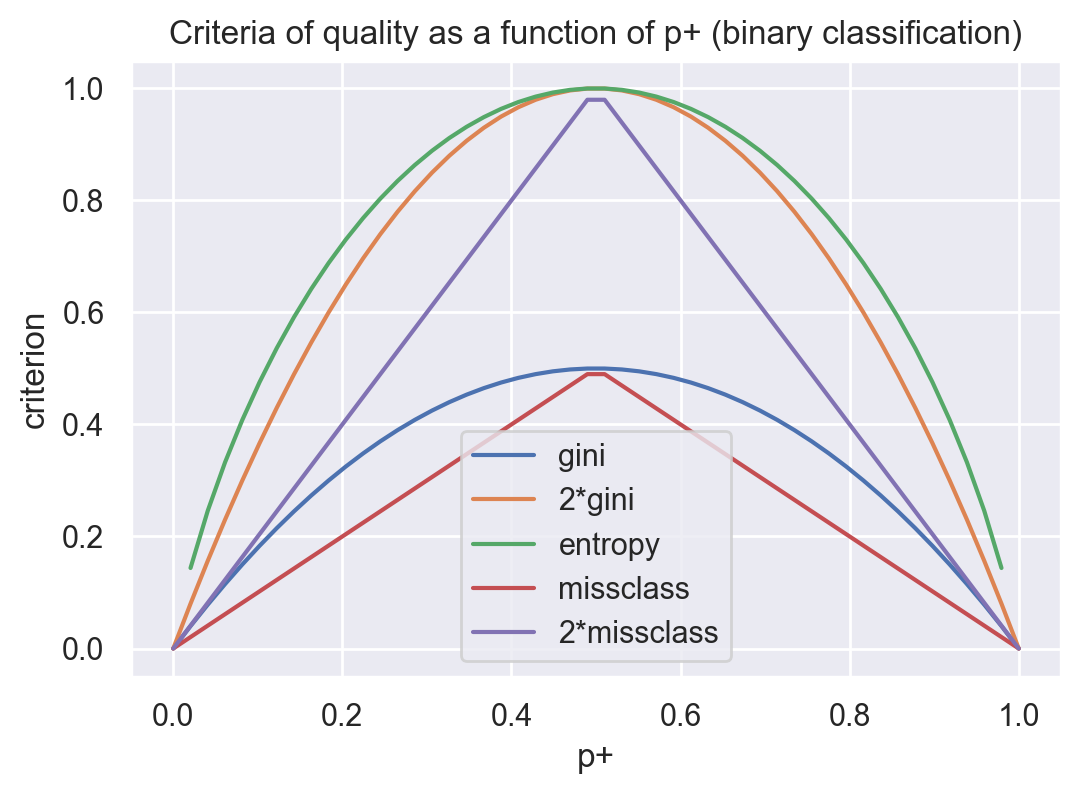

In [7]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label="gini")
plt.plot(xx, [4 * x * (1 - x) for x in xx], label="2*gini")
plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
plt.plot(xx, [1 - max(x, 1 - x) for x in xx], label="missclass")
plt.plot(xx, [2 - 2 * max(x, 1 - x) for x in xx], label="2*missclass")
plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Criteria of quality as a function of p+ (binary classification)")
plt.legend();

Example
Let’s consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [8]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Let’s plot the data. Informally, the classification problem in this case is to build some “good” boundary separating the two classes (the red dots from the yellow). Machine learning for this case boils down to choosing a good separating border. A straight line will be too simple while some complex curve snaking by each red dot will be too complex and will lead us to making mistakes on new samples. Intuitively, some smooth boundary, or at least a straight line or a hyperplane, would work well on new data.

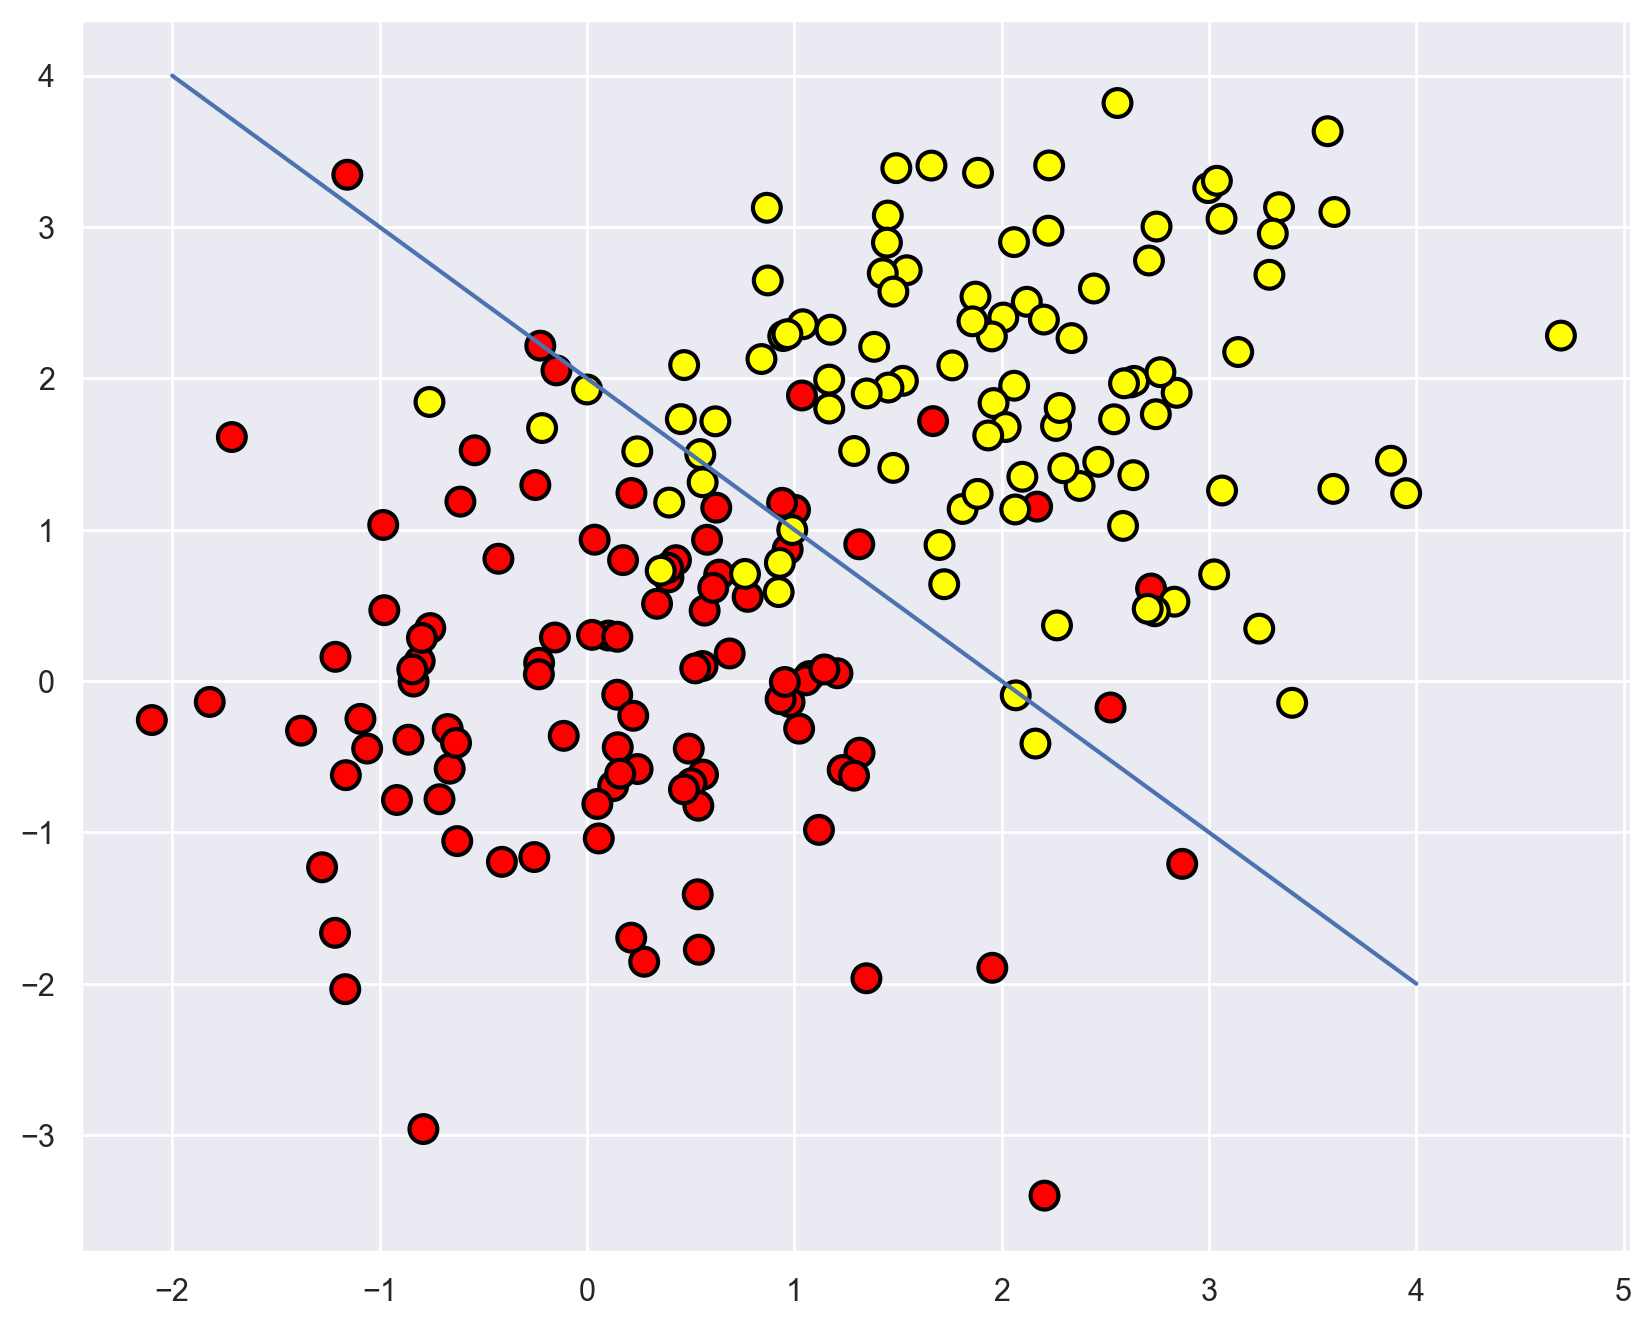

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1));

Let’s try to separate these two classes by training an Sklearn decision tree. We will use max_depth parameter that limits the depth of the tree. Let’s visualize the resulting separating boundary.

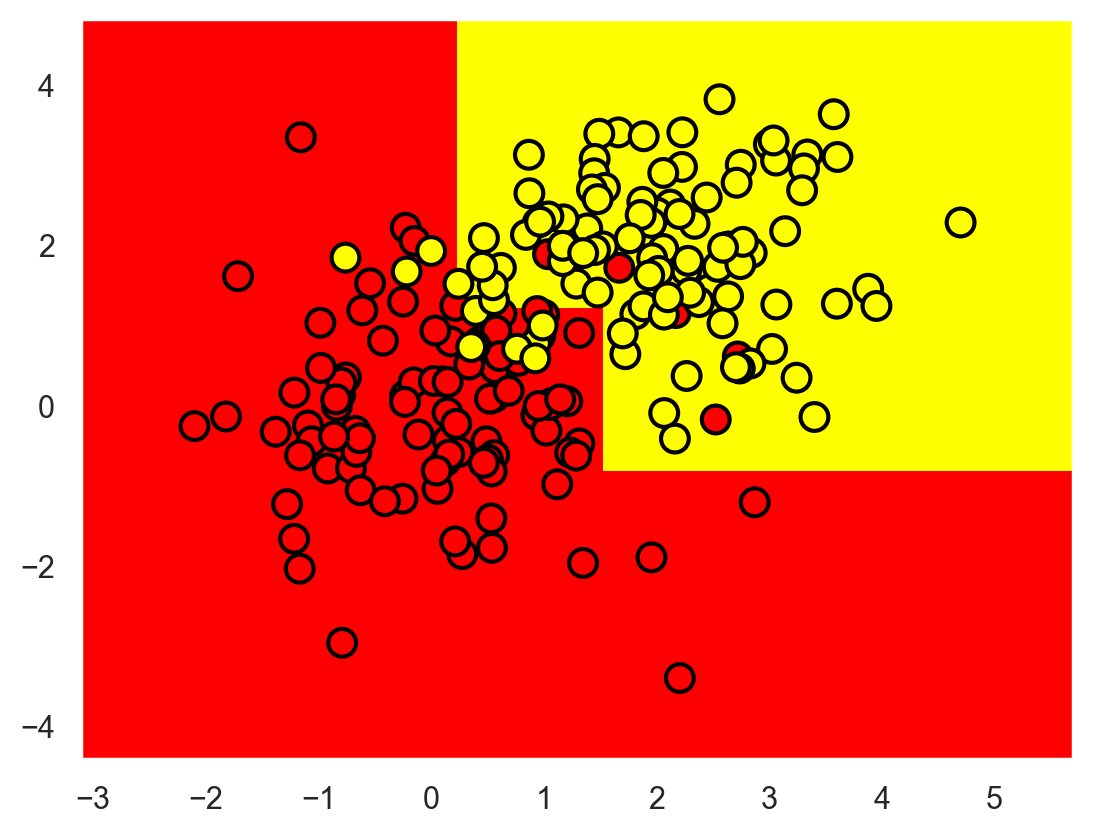

In [10]:
from sklearn.tree import DecisionTreeClassifier


# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
);

And how does the tree itself look? We see that the tree “cuts” the space into 8 rectangles, i.e. the tree has 8 leaves. Within each rectangle, the tree will make the prediction according to the majority label of the objects inside it.

In [11]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [12]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=["x1", "x2"],
    png_file_to_save="topic3_decision_tree1.png",
)

How can we “read” such a tree?
In the beginning, there were 200 samples (instances), 100 of each class. The entropy of the initial state was maximal, 
. Then, the first partition of the samples into 2 groups was made by comparing the value of 
 with 
 (find this part of the border in the picture above). With that, the entropy of both left and right groups decreased. The process continues up to depth 3. In this visualization, the more samples of the first class, the darker the orange color of the vertex; the more samples of the second class, the darker the blue. At the beginning, the number of samples from two classes is equal, so the root node of the tree is white.

How a Decision Tree Works with Numerical Features
Suppose we have a numeric feature “Age” that has a lot of unique values. A decision tree will look for the best (according to some criterion of information gain) split by checking binary attributes such as “Age <17”, “Age < 22.87”, and so on. But what if the age range is large? Or what if another quantitative variable, “salary”, can also be “cut” in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.

Let’s consider an example. Suppose we have the following dataset:

In [13]:
data = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data.sort_values("Age")

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [14]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data["Age"].values.reshape(-1, 1), data["Loan Default"].values)

tree_graph_to_png(
    age_tree,
    feature_names=["Age"],
    png_file_to_save="topic3_decision_tree2.png",
)

We see that the tree used the following 5 values to evaluate by age: 43.5, 19, 22.5, 30, and 32 years. If you look closely, these are exactly the mean values between the ages at which the target class “switches” from 1 to 0 or 0 to 1. To illustrate further, 43.5 is the average of 38 and 49 years; a 38-year-old customer failed to return the loan whereas the 49-year-old did. The tree looks for the values at which the target class switches its value as a threshold for “cutting” a quantitative variable.

Given this information, why do you think it makes no sense here to consider a feature like “Age <17.5”?

Let’s consider a more complex example by adding the “Salary” variable (in the thousands of dollars per year).

In [16]:
data2 = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Salary": [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data2.sort_values("Age")

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [17]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[["Age", "Salary"]].values, data2["Loan Default"].values);

In [18]:
tree_graph_to_png(
    tree=age_sal_tree,
    feature_names=["Age", "Salary"],
    png_file_to_save="topic3_decision_tree3.png",
)

We see that the tree partitioned by both salary and age. Moreover, the thresholds for feature comparisons are 43.5 and 22.5 years of age and 95k and 30.5k per year. Again, we see that 95 is the average between 88 and 102; the individual with a salary of 88k proved to be “bad” while the one with 102k was “good”. The same goes for 30.5k. That is, only a few values for comparisons by age and salary were searched. Why did the tree choose these features? Because they gave better partitioning (according to Gini uncertainty).

Conclusion: the simplest heuristics for handling numeric features in a decision tree is to sort its values in ascending order and check only those thresholds where the value of the target variable changes.

Furthermore, when there are a lot of numeric features in a dataset, each with a lot of unique values, only the top-N of the thresholds described above are selected, i.e. only use the top-N that give maximum gain. The process is to construct a tree of depth 1, compute the entropy (or Gini uncertainty), and select the best thresholds for comparison.

To illustrate, if we split by “Salary 
 34.5”, the left subgroup will have an entropy of 0 (all clients are “bad”), and the right one will have an entropy of 0.954 (3 “bad” and 5 “good”, you can check this yourself as it will be part of the assignment). The information gain is roughly 0.3. If we split by “Salary 
 95”, the left subgroup will have the entropy of 0.97 (6 “bad” and 4 “good”), and the right one will have the entropy of 0 (a group containing only one object). The information gain is about 0.11. If we calculate information gain for each partition in that manner, we can select the thresholds for comparison of each numeric feature before the construction of a large tree (using all features).

Example
Let’s generate some data distributed by the function 
 with some noise. Then we will train a tree with this data and predictions that the tree makes.

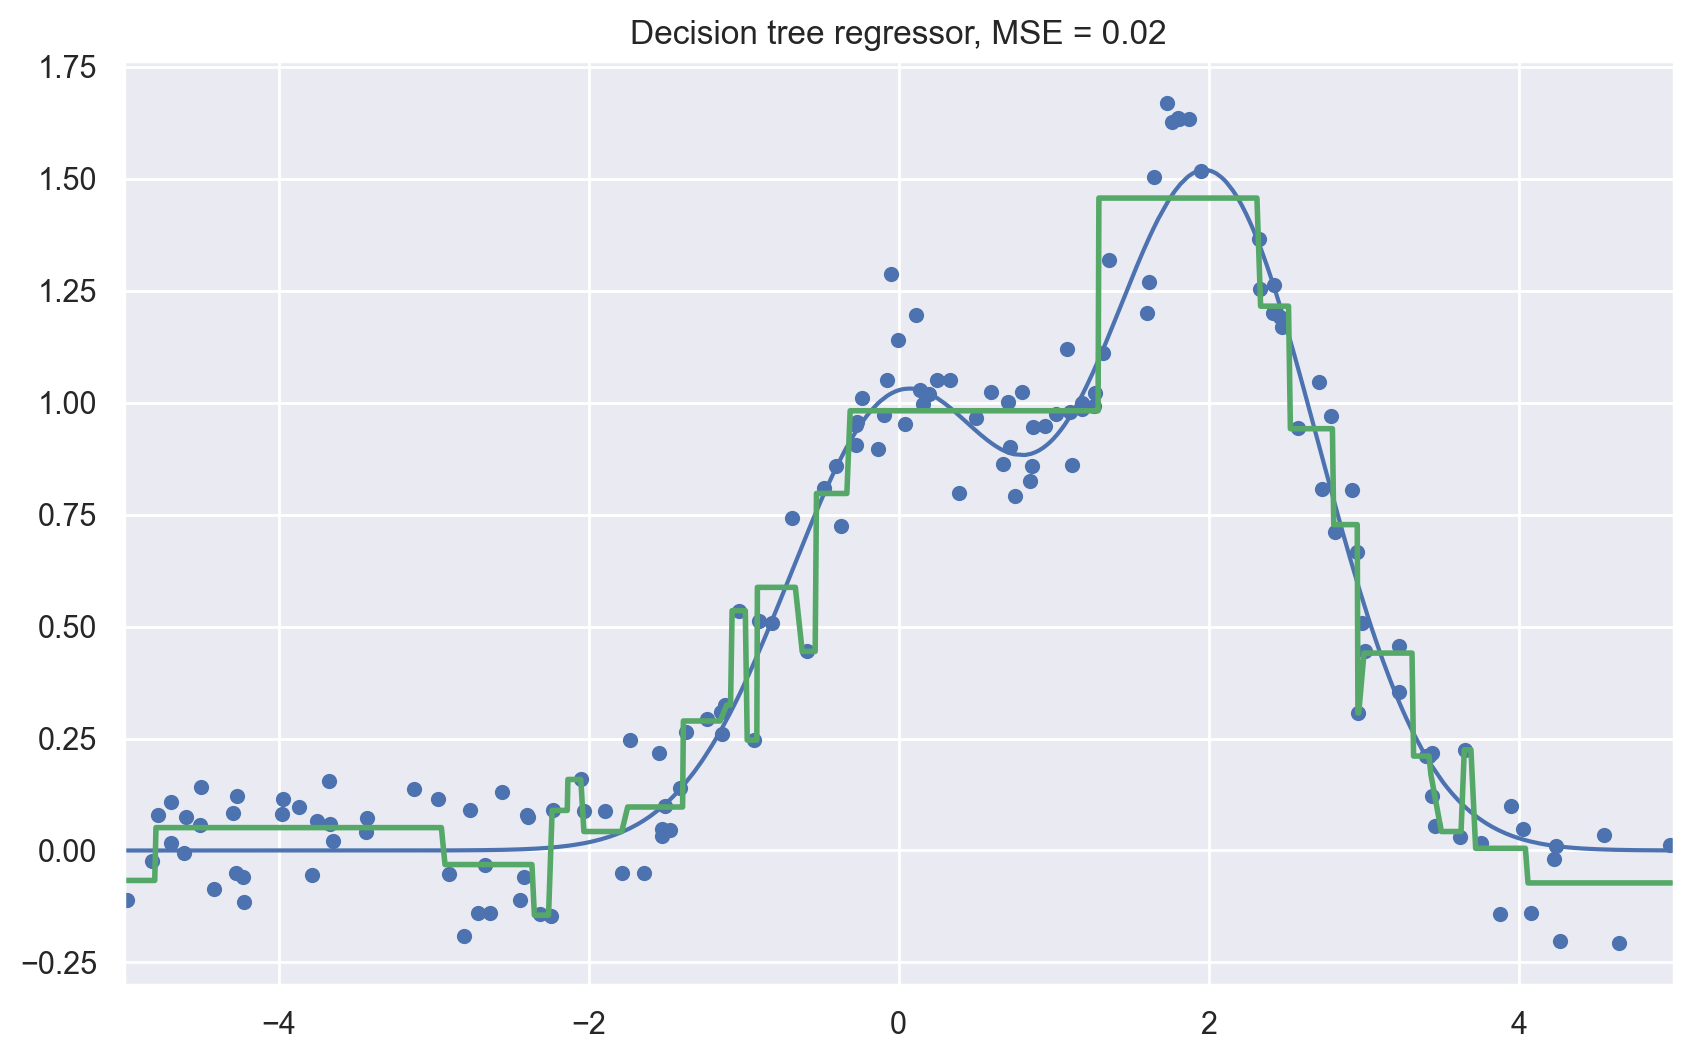

In [19]:
n_train = 150
n_test = 1000
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = (
        np.exp(-(X ** 2))
        + 1.5 * np.exp(-((X - 2) ** 2))
        + np.random.normal(0.0, noise, n_samples)
    )
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title(
    "Decision tree regressor, MSE = %.2f"
    % (np.sum((y_test - reg_tree_pred) ** 2) / n_test)
)
plt.show()

We see that the decision tree approximates the data with a piecewise constant function.